# Neural Machine Translation


Build a NMT model (with attention) to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). 


In [6]:
import keras
print (keras.__version__)
import tensorflow
print (tensorflow.__version__)

2.2.2
1.10.0


In [7]:

import tqdm
print (tqdm.__version__)

4.23.4


In [8]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1 - Translating human readable dates into machine readable dates

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 



<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [9]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 17923.72it/s]


In [10]:
dataset[:10]

[('29 may 1984', '1984-05-29'),
 ('thursday january 10 2013', '2013-01-10'),
 ('saturday august 4 1973', '1973-08-04'),
 ('9/6/84', '1984-09-06'),
 ('monday september 28 2009', '2009-09-28'),
 ('thursday december 29 2005', '2005-12-29'),
 ('22 jan 1991', '1991-01-22'),
 ('2 09 04', '2004-09-02'),
 ('thursday october 19 1995', '1995-10-19'),
 ('friday september 7 1979', '1979-09-07')]

In [11]:
print (len(dataset))
print (len(human_vocab))
print (len(machine_vocab))
print (len(inv_machine_vocab))

10000
37
11
11


In [12]:
print ("human_vocab :",human_vocab)
print ("machine_vocab: ",machine_vocab)
print ("inv_machine_vocab :", inv_machine_vocab)

human_vocab : {' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}
machine_vocab:  {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
inv_machine_vocab : {0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


Preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

In [13]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [14]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 29 may 1984
Target date: 1984-05-29

Source after preprocessing (indices): [ 5 12  0 24 13 34  0  4 12 11  7 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  5  0  1  6  0  3 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [15]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [16]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    """
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])
    return context

In [17]:
len(machine_vocab)

11

In [18]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [19]:
print ("n_a:", n_a)
print ("n_s:", n_s)

n_a: 32
n_s: 64


In [20]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0') # why is this shape rank 0 vector? is this always done?
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    outputs = []
    encoder_lstm=Bidirectional(LSTM(n_a, return_sequences=True))
    a = encoder_lstm(X)
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    return model

In [21]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0') # why is this shape rank 0 vector? is this always done?
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    outputs = []
    encoder_lstm=Bidirectional(LSTM(n_a, return_sequences=True))
    a = encoder_lstm(X)
    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    return model

In [22]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

In [24]:
out = model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')
out


- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [22]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [24]:
model.fit([Xoh, s0, c0], outputs, epochs=1000, batch_size=100)

Epoch 1/1000
10000/10000 [==============================] - 26s - loss: 2.3334 - dense_4_loss_1: 0.0384 - dense_4_loss_2: 0.0231 - dense_4_loss_3: 0.2425 - dense_4_loss_4: 0.5516 - dense_4_loss_5: 0.0077 - dense_4_loss_6: 0.0786 - dense_4_loss_7: 0.4928 - dense_4_loss_8: 0.0057 - dense_4_loss_9: 0.4019 - dense_4_loss_10: 0.4909 - dense_4_acc_1: 0.9903 - dense_4_acc_2: 0.9923 - dense_4_acc_3: 0.9131 - dense_4_acc_4: 0.8712 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9782 - dense_4_acc_7: 0.8818 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.8652 - dense_4_acc_10: 0.8435    
Epoch 2/1000
10000/10000 [==============================] - 27s - loss: 2.1174 - dense_4_loss_1: 0.0352 - dense_4_loss_2: 0.0198 - dense_4_loss_3: 0.2234 - dense_4_loss_4: 0.4856 - dense_4_loss_5: 0.0072 - dense_4_loss_6: 0.0749 - dense_4_loss_7: 0.4382 - dense_4_loss_8: 0.0052 - dense_4_loss_9: 0.3772 - dense_4_loss_10: 0.4506 - dense_4_acc_1: 0.9917 - dense_4_acc_2: 0.9937 - dense_4_acc_3: 0.9239 - dense_4_acc_4: 0.8897

10000/10000 [==============================] - 26s - loss: 0.6105 - dense_4_loss_1: 0.0079 - dense_4_loss_2: 0.0029 - dense_4_loss_3: 0.0446 - dense_4_loss_4: 0.0813 - dense_4_loss_5: 0.0019 - dense_4_loss_6: 0.0331 - dense_4_loss_7: 0.1512 - dense_4_loss_8: 0.0017 - dense_4_loss_9: 0.1048 - dense_4_loss_10: 0.1812 - dense_4_acc_1: 0.9985 - dense_4_acc_2: 0.9999 - dense_4_acc_3: 0.9924 - dense_4_acc_4: 0.9974 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9893 - dense_4_acc_7: 0.9579 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9752 - dense_4_acc_10: 0.9466    
Epoch 30/1000
10000/10000 [==============================] - 26s - loss: 0.5935 - dense_4_loss_1: 0.0076 - dense_4_loss_2: 0.0027 - dense_4_loss_3: 0.0430 - dense_4_loss_4: 0.0778 - dense_4_loss_5: 0.0017 - dense_4_loss_6: 0.0326 - dense_4_loss_7: 0.1500 - dense_4_loss_8: 0.0017 - dense_4_loss_9: 0.1009 - dense_4_loss_10: 0.1754 - dense_4_acc_1: 0.9987 - dense_4_acc_2: 0.9999 - dense_4_acc_3: 0.9938 - dense_4_acc_4: 0.9978 - dense_4_a

10000/10000 [==============================] - 25s - loss: 0.3392 - dense_4_loss_1: 0.0040 - dense_4_loss_2: 0.0013 - dense_4_loss_3: 0.0188 - dense_4_loss_4: 0.0364 - dense_4_loss_5: 8.0250e-04 - dense_4_loss_6: 0.0227 - dense_4_loss_7: 0.1068 - dense_4_loss_8: 8.7852e-04 - dense_4_loss_9: 0.0523 - dense_4_loss_10: 0.0952 - dense_4_acc_1: 0.9996 - dense_4_acc_2: 0.9999 - dense_4_acc_3: 0.9985 - dense_4_acc_4: 0.9992 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9927 - dense_4_acc_7: 0.9681 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9899 - dense_4_acc_10: 0.9798    
Epoch 58/1000
10000/10000 [==============================] - 25s - loss: 0.3372 - dense_4_loss_1: 0.0040 - dense_4_loss_2: 0.0013 - dense_4_loss_3: 0.0184 - dense_4_loss_4: 0.0359 - dense_4_loss_5: 7.9302e-04 - dense_4_loss_6: 0.0232 - dense_4_loss_7: 0.1066 - dense_4_loss_8: 8.7493e-04 - dense_4_loss_9: 0.0519 - dense_4_loss_10: 0.0941 - dense_4_acc_1: 0.9995 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9984 - dense_4_acc_4: 0.

10000/10000 [==============================] - 25s - loss: 0.2388 - dense_4_loss_1: 0.0029 - dense_4_loss_2: 8.7792e-04 - dense_4_loss_3: 0.0117 - dense_4_loss_4: 0.0235 - dense_4_loss_5: 4.4711e-04 - dense_4_loss_6: 0.0176 - dense_4_loss_7: 0.0840 - dense_4_loss_8: 5.1512e-04 - dense_4_loss_9: 0.0354 - dense_4_loss_10: 0.0620 - dense_4_acc_1: 0.9997 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9993 - dense_4_acc_4: 0.9996 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9942 - dense_4_acc_7: 0.9747 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9926 - dense_4_acc_10: 0.9858    
Epoch 85/1000
10000/10000 [==============================] - 25s - loss: 0.2370 - dense_4_loss_1: 0.0028 - dense_4_loss_2: 8.4865e-04 - dense_4_loss_3: 0.0116 - dense_4_loss_4: 0.0232 - dense_4_loss_5: 4.3372e-04 - dense_4_loss_6: 0.0174 - dense_4_loss_7: 0.0833 - dense_4_loss_8: 5.0847e-04 - dense_4_loss_9: 0.0354 - dense_4_loss_10: 0.0615 - dense_4_acc_1: 0.9997 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9993 - dense_4_a

10000/10000 [==============================] - 25s - loss: 0.1881 - dense_4_loss_1: 0.0023 - dense_4_loss_2: 6.8496e-04 - dense_4_loss_3: 0.0084 - dense_4_loss_4: 0.0175 - dense_4_loss_5: 2.8082e-04 - dense_4_loss_6: 0.0136 - dense_4_loss_7: 0.0708 - dense_4_loss_8: 3.2956e-04 - dense_4_loss_9: 0.0277 - dense_4_loss_10: 0.0465 - dense_4_acc_1: 0.9998 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9994 - dense_4_acc_4: 0.9998 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9955 - dense_4_acc_7: 0.9796 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9943 - dense_4_acc_10: 0.9905    
Epoch 111/1000
10000/10000 [==============================] - 25s - loss: 0.1861 - dense_4_loss_1: 0.0022 - dense_4_loss_2: 6.6276e-04 - dense_4_loss_3: 0.0084 - dense_4_loss_4: 0.0174 - dense_4_loss_5: 2.6802e-04 - dense_4_loss_6: 0.0137 - dense_4_loss_7: 0.0699 - dense_4_loss_8: 3.2642e-04 - dense_4_loss_9: 0.0275 - dense_4_loss_10: 0.0457 - dense_4_acc_1: 0.9998 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9994 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.1542 - dense_4_loss_1: 0.0019 - dense_4_loss_2: 5.6937e-04 - dense_4_loss_3: 0.0066 - dense_4_loss_4: 0.0141 - dense_4_loss_5: 1.9721e-04 - dense_4_loss_6: 0.0113 - dense_4_loss_7: 0.0601 - dense_4_loss_8: 2.4280e-04 - dense_4_loss_9: 0.0225 - dense_4_loss_10: 0.0366 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9996 - dense_4_acc_4: 0.9999 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9972 - dense_4_acc_7: 0.9832 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9951 - dense_4_acc_10: 0.9930    
Epoch 137/1000
10000/10000 [==============================] - 25s - loss: 0.1522 - dense_4_loss_1: 0.0019 - dense_4_loss_2: 5.4518e-04 - dense_4_loss_3: 0.0066 - dense_4_loss_4: 0.0141 - dense_4_loss_5: 1.8436e-04 - dense_4_loss_6: 0.0110 - dense_4_loss_7: 0.0593 - dense_4_loss_8: 2.3494e-04 - dense_4_loss_9: 0.0222 - dense_4_loss_10: 0.0360 - dense_4_acc_1: 0.9998 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9996 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.1293 - dense_4_loss_1: 0.0017 - dense_4_loss_2: 4.8940e-04 - dense_4_loss_3: 0.0055 - dense_4_loss_4: 0.0118 - dense_4_loss_5: 1.3622e-04 - dense_4_loss_6: 0.0094 - dense_4_loss_7: 0.0517 - dense_4_loss_8: 1.7944e-04 - dense_4_loss_9: 0.0185 - dense_4_loss_10: 0.0301 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9997 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9976 - dense_4_acc_7: 0.9864 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9960 - dense_4_acc_10: 0.9942    
Epoch 163/1000
10000/10000 [==============================] - 25s - loss: 0.1285 - dense_4_loss_1: 0.0017 - dense_4_loss_2: 4.8856e-04 - dense_4_loss_3: 0.0054 - dense_4_loss_4: 0.0119 - dense_4_loss_5: 1.4519e-04 - dense_4_loss_6: 0.0092 - dense_4_loss_7: 0.0516 - dense_4_loss_8: 1.8003e-04 - dense_4_loss_9: 0.0181 - dense_4_loss_10: 0.0299 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9996 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.1119 - dense_4_loss_1: 0.0015 - dense_4_loss_2: 4.3597e-04 - dense_4_loss_3: 0.0047 - dense_4_loss_4: 0.0104 - dense_4_loss_5: 1.0668e-04 - dense_4_loss_6: 0.0080 - dense_4_loss_7: 0.0455 - dense_4_loss_8: 1.4488e-04 - dense_4_loss_9: 0.0157 - dense_4_loss_10: 0.0254 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9982 - dense_4_acc_7: 0.9886 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9969 - dense_4_acc_10: 0.9955    
Epoch 189/1000
10000/10000 [==============================] - 25s - loss: 0.1108 - dense_4_loss_1: 0.0015 - dense_4_loss_2: 4.3116e-04 - dense_4_loss_3: 0.0046 - dense_4_loss_4: 0.0103 - dense_4_loss_5: 1.0551e-04 - dense_4_loss_6: 0.0080 - dense_4_loss_7: 0.0455 - dense_4_loss_8: 1.4756e-04 - dense_4_loss_9: 0.0153 - dense_4_loss_10: 0.0250 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0974 - dense_4_loss_1: 0.0014 - dense_4_loss_2: 3.9071e-04 - dense_4_loss_3: 0.0041 - dense_4_loss_4: 0.0092 - dense_4_loss_5: 9.6751e-05 - dense_4_loss_6: 0.0068 - dense_4_loss_7: 0.0404 - dense_4_loss_8: 1.2407e-04 - dense_4_loss_9: 0.0133 - dense_4_loss_10: 0.0216 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9986 - dense_4_acc_7: 0.9905 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9972 - dense_4_acc_10: 0.9965    
Epoch 215/1000
10000/10000 [==============================] - 25s - loss: 0.0974 - dense_4_loss_1: 0.0013 - dense_4_loss_2: 3.9191e-04 - dense_4_loss_3: 0.0040 - dense_4_loss_4: 0.0092 - dense_4_loss_5: 8.8699e-05 - dense_4_loss_6: 0.0070 - dense_4_loss_7: 0.0406 - dense_4_loss_8: 1.2110e-04 - dense_4_loss_9: 0.0132 - dense_4_loss_10: 0.0216 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0868 - dense_4_loss_1: 0.0012 - dense_4_loss_2: 3.5542e-04 - dense_4_loss_3: 0.0036 - dense_4_loss_4: 0.0083 - dense_4_loss_5: 8.5619e-05 - dense_4_loss_6: 0.0060 - dense_4_loss_7: 0.0365 - dense_4_loss_8: 1.1130e-04 - dense_4_loss_9: 0.0116 - dense_4_loss_10: 0.0190 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9990 - dense_4_acc_7: 0.9917 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9977 - dense_4_acc_10: 0.9971    
Epoch 241/1000
10000/10000 [==============================] - 25s - loss: 0.0860 - dense_4_loss_1: 0.0012 - dense_4_loss_2: 3.5915e-04 - dense_4_loss_3: 0.0036 - dense_4_loss_4: 0.0082 - dense_4_loss_5: 8.0517e-05 - dense_4_loss_6: 0.0060 - dense_4_loss_7: 0.0361 - dense_4_loss_8: 1.0520e-04 - dense_4_loss_9: 0.0114 - dense_4_loss_10: 0.0190 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9998 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0773 - dense_4_loss_1: 0.0011 - dense_4_loss_2: 3.2524e-04 - dense_4_loss_3: 0.0032 - dense_4_loss_4: 0.0075 - dense_4_loss_5: 7.4581e-05 - dense_4_loss_6: 0.0053 - dense_4_loss_7: 0.0328 - dense_4_loss_8: 9.0617e-05 - dense_4_loss_9: 0.0101 - dense_4_loss_10: 0.0168 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9999 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9992 - dense_4_acc_7: 0.9925 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9981 - dense_4_acc_10: 0.9976    
Epoch 267/1000
10000/10000 [==============================] - 25s - loss: 0.0772 - dense_4_loss_1: 0.0011 - dense_4_loss_2: 3.2445e-04 - dense_4_loss_3: 0.0032 - dense_4_loss_4: 0.0075 - dense_4_loss_5: 7.1616e-05 - dense_4_loss_6: 0.0054 - dense_4_loss_7: 0.0328 - dense_4_loss_8: 9.5886e-05 - dense_4_loss_9: 0.0101 - dense_4_loss_10: 0.0166 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9999 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0697 - dense_4_loss_1: 0.0010 - dense_4_loss_2: 3.0169e-04 - dense_4_loss_3: 0.0029 - dense_4_loss_4: 0.0069 - dense_4_loss_5: 6.0897e-05 - dense_4_loss_6: 0.0048 - dense_4_loss_7: 0.0299 - dense_4_loss_8: 8.3971e-05 - dense_4_loss_9: 0.0089 - dense_4_loss_10: 0.0148 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 0.9999 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9994 - dense_4_acc_7: 0.9937 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9984 - dense_4_acc_10: 0.9983    
Epoch 293/1000
10000/10000 [==============================] - 25s - loss: 0.0695 - dense_4_loss_1: 0.0010 - dense_4_loss_2: 3.0266e-04 - dense_4_loss_3: 0.0029 - dense_4_loss_4: 0.0069 - dense_4_loss_5: 5.8246e-05 - dense_4_loss_6: 0.0047 - dense_4_loss_7: 0.0299 - dense_4_loss_8: 8.0965e-05 - dense_4_loss_9: 0.0088 - dense_4_loss_10: 0.0149 - dense_4_acc_1: 0.9999 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0630 - dense_4_loss_1: 9.3803e-04 - dense_4_loss_2: 2.8114e-04 - dense_4_loss_3: 0.0027 - dense_4_loss_4: 0.0064 - dense_4_loss_5: 5.5731e-05 - dense_4_loss_6: 0.0042 - dense_4_loss_7: 0.0271 - dense_4_loss_8: 7.8034e-05 - dense_4_loss_9: 0.0079 - dense_4_loss_10: 0.0133 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9996 - dense_4_acc_7: 0.9944 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9987 - dense_4_acc_10: 0.9984    
Epoch 319/1000
10000/10000 [==============================] - 25s - loss: 0.0628 - dense_4_loss_1: 9.4561e-04 - dense_4_loss_2: 2.8264e-04 - dense_4_loss_3: 0.0027 - dense_4_loss_4: 0.0064 - dense_4_loss_5: 6.1650e-05 - dense_4_loss_6: 0.0043 - dense_4_loss_7: 0.0271 - dense_4_loss_8: 7.7066e-05 - dense_4_loss_9: 0.0078 - dense_4_loss_10: 0.0133 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0576 - dense_4_loss_1: 8.6112e-04 - dense_4_loss_2: 2.6476e-04 - dense_4_loss_3: 0.0025 - dense_4_loss_4: 0.0059 - dense_4_loss_5: 4.8069e-05 - dense_4_loss_6: 0.0039 - dense_4_loss_7: 0.0248 - dense_4_loss_8: 6.8499e-05 - dense_4_loss_9: 0.0071 - dense_4_loss_10: 0.0121 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9997 - dense_4_acc_7: 0.9947 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9989 - dense_4_acc_10: 0.9989    
Epoch 345/1000
10000/10000 [==============================] - 25s - loss: 0.0574 - dense_4_loss_1: 8.8504e-04 - dense_4_loss_2: 2.6319e-04 - dense_4_loss_3: 0.0025 - dense_4_loss_4: 0.0059 - dense_4_loss_5: 5.0551e-05 - dense_4_loss_6: 0.0038 - dense_4_loss_7: 0.0248 - dense_4_loss_8: 7.0511e-05 - dense_4_loss_9: 0.0071 - dense_4_loss_10: 0.0120 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0528 - dense_4_loss_1: 8.0375e-04 - dense_4_loss_2: 2.4577e-04 - dense_4_loss_3: 0.0023 - dense_4_loss_4: 0.0055 - dense_4_loss_5: 4.4437e-05 - dense_4_loss_6: 0.0035 - dense_4_loss_7: 0.0230 - dense_4_loss_8: 6.3406e-05 - dense_4_loss_9: 0.0064 - dense_4_loss_10: 0.0109 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9997 - dense_4_acc_7: 0.9952 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9989 - dense_4_acc_10: 0.9993    
Epoch 371/1000
10000/10000 [==============================] - 25s - loss: 0.0525 - dense_4_loss_1: 8.0406e-04 - dense_4_loss_2: 2.4533e-04 - dense_4_loss_3: 0.0023 - dense_4_loss_4: 0.0055 - dense_4_loss_5: 4.4507e-05 - dense_4_loss_6: 0.0035 - dense_4_loss_7: 0.0228 - dense_4_loss_8: 6.3513e-05 - dense_4_loss_9: 0.0063 - dense_4_loss_10: 0.0109 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0486 - dense_4_loss_1: 7.4917e-04 - dense_4_loss_2: 2.3353e-04 - dense_4_loss_3: 0.0021 - dense_4_loss_4: 0.0052 - dense_4_loss_5: 4.3982e-05 - dense_4_loss_6: 0.0033 - dense_4_loss_7: 0.0210 - dense_4_loss_8: 6.0657e-05 - dense_4_loss_9: 0.0058 - dense_4_loss_10: 0.0101 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9998 - dense_4_acc_7: 0.9960 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9992 - dense_4_acc_10: 0.9994    
Epoch 397/1000
10000/10000 [==============================] - 25s - loss: 0.0484 - dense_4_loss_1: 7.4824e-04 - dense_4_loss_2: 2.3087e-04 - dense_4_loss_3: 0.0021 - dense_4_loss_4: 0.0051 - dense_4_loss_5: 4.3067e-05 - dense_4_loss_6: 0.0032 - dense_4_loss_7: 0.0210 - dense_4_loss_8: 5.7881e-05 - dense_4_loss_9: 0.0058 - dense_4_loss_10: 0.0100 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0450 - dense_4_loss_1: 7.0796e-04 - dense_4_loss_2: 2.1889e-04 - dense_4_loss_3: 0.0020 - dense_4_loss_4: 0.0049 - dense_4_loss_5: 3.9206e-05 - dense_4_loss_6: 0.0030 - dense_4_loss_7: 0.0196 - dense_4_loss_8: 5.5286e-05 - dense_4_loss_9: 0.0053 - dense_4_loss_10: 0.0092 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9998 - dense_4_acc_7: 0.9965 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9993 - dense_4_acc_10: 0.9994    
Epoch 423/1000
10000/10000 [==============================] - 25s - loss: 0.0447 - dense_4_loss_1: 6.9509e-04 - dense_4_loss_2: 2.2210e-04 - dense_4_loss_3: 0.0020 - dense_4_loss_4: 0.0048 - dense_4_loss_5: 4.0798e-05 - dense_4_loss_6: 0.0029 - dense_4_loss_7: 0.0195 - dense_4_loss_8: 5.5879e-05 - dense_4_loss_9: 0.0053 - dense_4_loss_10: 0.0092 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0416 - dense_4_loss_1: 6.6097e-04 - dense_4_loss_2: 2.0666e-04 - dense_4_loss_3: 0.0019 - dense_4_loss_4: 0.0046 - dense_4_loss_5: 3.8317e-05 - dense_4_loss_6: 0.0027 - dense_4_loss_7: 0.0180 - dense_4_loss_8: 5.2385e-05 - dense_4_loss_9: 0.0049 - dense_4_loss_10: 0.0085 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9998 - dense_4_acc_7: 0.9971 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9994 - dense_4_acc_10: 0.9995    
Epoch 449/1000
10000/10000 [==============================] - 25s - loss: 0.0415 - dense_4_loss_1: 6.4981e-04 - dense_4_loss_2: 2.1008e-04 - dense_4_loss_3: 0.0019 - dense_4_loss_4: 0.0046 - dense_4_loss_5: 3.6460e-05 - dense_4_loss_6: 0.0027 - dense_4_loss_7: 0.0181 - dense_4_loss_8: 5.2485e-05 - dense_4_loss_9: 0.0049 - dense_4_loss_10: 0.0084 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0386 - dense_4_loss_1: 6.1807e-04 - dense_4_loss_2: 1.9975e-04 - dense_4_loss_3: 0.0018 - dense_4_loss_4: 0.0044 - dense_4_loss_5: 3.5628e-05 - dense_4_loss_6: 0.0025 - dense_4_loss_7: 0.0168 - dense_4_loss_8: 4.9354e-05 - dense_4_loss_9: 0.0045 - dense_4_loss_10: 0.0078 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9998 - dense_4_acc_7: 0.9976 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9994 - dense_4_acc_10: 0.9995    
Epoch 475/1000
10000/10000 [==============================] - 25s - loss: 0.0386 - dense_4_loss_1: 6.1151e-04 - dense_4_loss_2: 2.0157e-04 - dense_4_loss_3: 0.0017 - dense_4_loss_4: 0.0043 - dense_4_loss_5: 3.5079e-05 - dense_4_loss_6: 0.0025 - dense_4_loss_7: 0.0168 - dense_4_loss_8: 5.0028e-05 - dense_4_loss_9: 0.0045 - dense_4_loss_10: 0.0079 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0361 - dense_4_loss_1: 5.8104e-04 - dense_4_loss_2: 1.8860e-04 - dense_4_loss_3: 0.0016 - dense_4_loss_4: 0.0041 - dense_4_loss_5: 3.2991e-05 - dense_4_loss_6: 0.0023 - dense_4_loss_7: 0.0157 - dense_4_loss_8: 4.6236e-05 - dense_4_loss_9: 0.0042 - dense_4_loss_10: 0.0073 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9998 - dense_4_acc_7: 0.9979 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9995 - dense_4_acc_10: 0.9995    
Epoch 501/1000
10000/10000 [==============================] - 25s - loss: 0.0360 - dense_4_loss_1: 5.8113e-04 - dense_4_loss_2: 1.8738e-04 - dense_4_loss_3: 0.0016 - dense_4_loss_4: 0.0041 - dense_4_loss_5: 3.2888e-05 - dense_4_loss_6: 0.0024 - dense_4_loss_7: 0.0156 - dense_4_loss_8: 4.6616e-05 - dense_4_loss_9: 0.0041 - dense_4_loss_10: 0.0073 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0337 - dense_4_loss_1: 5.4640e-04 - dense_4_loss_2: 1.8070e-04 - dense_4_loss_3: 0.0016 - dense_4_loss_4: 0.0039 - dense_4_loss_5: 2.9938e-05 - dense_4_loss_6: 0.0022 - dense_4_loss_7: 0.0146 - dense_4_loss_8: 4.4239e-05 - dense_4_loss_9: 0.0039 - dense_4_loss_10: 0.0068 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9999 - dense_4_acc_7: 0.9982 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9995 - dense_4_acc_10: 0.9995    
Epoch 527/1000
10000/10000 [==============================] - 25s - loss: 0.0335 - dense_4_loss_1: 5.3784e-04 - dense_4_loss_2: 1.7810e-04 - dense_4_loss_3: 0.0016 - dense_4_loss_4: 0.0039 - dense_4_loss_5: 3.0231e-05 - dense_4_loss_6: 0.0022 - dense_4_loss_7: 0.0146 - dense_4_loss_8: 4.4247e-05 - dense_4_loss_9: 0.0038 - dense_4_loss_10: 0.0067 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0316 - dense_4_loss_1: 5.0950e-04 - dense_4_loss_2: 1.7438e-04 - dense_4_loss_3: 0.0015 - dense_4_loss_4: 0.0037 - dense_4_loss_5: 2.8708e-05 - dense_4_loss_6: 0.0020 - dense_4_loss_7: 0.0137 - dense_4_loss_8: 4.3067e-05 - dense_4_loss_9: 0.0036 - dense_4_loss_10: 0.0063 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9999 - dense_4_acc_7: 0.9987 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9997 - dense_4_acc_10: 0.9996    
Epoch 553/1000
10000/10000 [==============================] - 25s - loss: 0.0315 - dense_4_loss_1: 5.1753e-04 - dense_4_loss_2: 1.7073e-04 - dense_4_loss_3: 0.0015 - dense_4_loss_4: 0.0037 - dense_4_loss_5: 2.9420e-05 - dense_4_loss_6: 0.0020 - dense_4_loss_7: 0.0137 - dense_4_loss_8: 4.3547e-05 - dense_4_loss_9: 0.0036 - dense_4_loss_10: 0.0063 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0296 - dense_4_loss_1: 4.8607e-04 - dense_4_loss_2: 1.6464e-04 - dense_4_loss_3: 0.0014 - dense_4_loss_4: 0.0035 - dense_4_loss_5: 2.7337e-05 - dense_4_loss_6: 0.0019 - dense_4_loss_7: 0.0128 - dense_4_loss_8: 4.1362e-05 - dense_4_loss_9: 0.0033 - dense_4_loss_10: 0.0059 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9988 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9998 - dense_4_acc_10: 0.9997    
Epoch 579/1000
10000/10000 [==============================] - 25s - loss: 0.0296 - dense_4_loss_1: 4.9255e-04 - dense_4_loss_2: 1.6611e-04 - dense_4_loss_3: 0.0014 - dense_4_loss_4: 0.0035 - dense_4_loss_5: 2.8211e-05 - dense_4_loss_6: 0.0019 - dense_4_loss_7: 0.0128 - dense_4_loss_8: 4.1271e-05 - dense_4_loss_9: 0.0034 - dense_4_loss_10: 0.0059 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0279 - dense_4_loss_1: 4.5690e-04 - dense_4_loss_2: 1.5743e-04 - dense_4_loss_3: 0.0013 - dense_4_loss_4: 0.0034 - dense_4_loss_5: 2.5516e-05 - dense_4_loss_6: 0.0018 - dense_4_loss_7: 0.0121 - dense_4_loss_8: 3.9071e-05 - dense_4_loss_9: 0.0031 - dense_4_loss_10: 0.0056 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9999 - dense_4_acc_7: 0.9988 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9998 - dense_4_acc_10: 0.9999    
Epoch 605/1000
10000/10000 [==============================] - 25s - loss: 0.0277 - dense_4_loss_1: 4.6452e-04 - dense_4_loss_2: 1.5623e-04 - dense_4_loss_3: 0.0013 - dense_4_loss_4: 0.0034 - dense_4_loss_5: 2.7034e-05 - dense_4_loss_6: 0.0018 - dense_4_loss_7: 0.0119 - dense_4_loss_8: 4.0206e-05 - dense_4_loss_9: 0.0031 - dense_4_loss_10: 0.0056 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0262 - dense_4_loss_1: 4.3103e-04 - dense_4_loss_2: 1.5105e-04 - dense_4_loss_3: 0.0013 - dense_4_loss_4: 0.0032 - dense_4_loss_5: 2.5419e-05 - dense_4_loss_6: 0.0017 - dense_4_loss_7: 0.0113 - dense_4_loss_8: 3.8650e-05 - dense_4_loss_9: 0.0029 - dense_4_loss_10: 0.0052 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 0.9999 - dense_4_acc_7: 0.9990 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9998 - dense_4_acc_10: 0.9999    
Epoch 631/1000
10000/10000 [==============================] - 24s - loss: 0.0261 - dense_4_loss_1: 4.3389e-04 - dense_4_loss_2: 1.4994e-04 - dense_4_loss_3: 0.0013 - dense_4_loss_4: 0.0032 - dense_4_loss_5: 2.5180e-05 - dense_4_loss_6: 0.0017 - dense_4_loss_7: 0.0113 - dense_4_loss_8: 3.7353e-05 - dense_4_loss_9: 0.0029 - dense_4_loss_10: 0.0052 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0247 - dense_4_loss_1: 4.1124e-04 - dense_4_loss_2: 1.4260e-04 - dense_4_loss_3: 0.0012 - dense_4_loss_4: 0.0031 - dense_4_loss_5: 2.4347e-05 - dense_4_loss_6: 0.0016 - dense_4_loss_7: 0.0106 - dense_4_loss_8: 3.7109e-05 - dense_4_loss_9: 0.0027 - dense_4_loss_10: 0.0049 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9991 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9999 - dense_4_acc_10: 0.9999    
Epoch 657/1000
10000/10000 [==============================] - 25s - loss: 0.0247 - dense_4_loss_1: 4.1315e-04 - dense_4_loss_2: 1.4451e-04 - dense_4_loss_3: 0.0012 - dense_4_loss_4: 0.0031 - dense_4_loss_5: 2.4057e-05 - dense_4_loss_6: 0.0016 - dense_4_loss_7: 0.0106 - dense_4_loss_8: 3.6347e-05 - dense_4_loss_9: 0.0027 - dense_4_loss_10: 0.0049 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0233 - dense_4_loss_1: 3.9044e-04 - dense_4_loss_2: 1.3804e-04 - dense_4_loss_3: 0.0012 - dense_4_loss_4: 0.0029 - dense_4_loss_5: 2.2487e-05 - dense_4_loss_6: 0.0015 - dense_4_loss_7: 0.0100 - dense_4_loss_8: 3.4922e-05 - dense_4_loss_9: 0.0026 - dense_4_loss_10: 0.0046 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9992 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9998 - dense_4_acc_10: 1.0000    
Epoch 683/1000
10000/10000 [==============================] - 25s - loss: 0.0233 - dense_4_loss_1: 3.9035e-04 - dense_4_loss_2: 1.3675e-04 - dense_4_loss_3: 0.0012 - dense_4_loss_4: 0.0029 - dense_4_loss_5: 2.2416e-05 - dense_4_loss_6: 0.0014 - dense_4_loss_7: 0.0099 - dense_4_loss_8: 3.5451e-05 - dense_4_loss_9: 0.0026 - dense_4_loss_10: 0.0046 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 24s - loss: 0.0221 - dense_4_loss_1: 3.7239e-04 - dense_4_loss_2: 1.3277e-04 - dense_4_loss_3: 0.0011 - dense_4_loss_4: 0.0028 - dense_4_loss_5: 2.2153e-05 - dense_4_loss_6: 0.0014 - dense_4_loss_7: 0.0094 - dense_4_loss_8: 3.3848e-05 - dense_4_loss_9: 0.0025 - dense_4_loss_10: 0.0044 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9992 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9999 - dense_4_acc_10: 1.0000    
Epoch 709/1000
10000/10000 [==============================] - 25s - loss: 0.0220 - dense_4_loss_1: 3.7286e-04 - dense_4_loss_2: 1.3148e-04 - dense_4_loss_3: 0.0011 - dense_4_loss_4: 0.0028 - dense_4_loss_5: 2.2275e-05 - dense_4_loss_6: 0.0014 - dense_4_loss_7: 0.0094 - dense_4_loss_8: 3.3613e-05 - dense_4_loss_9: 0.0024 - dense_4_loss_10: 0.0044 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0210 - dense_4_loss_1: 3.5672e-04 - dense_4_loss_2: 1.2621e-04 - dense_4_loss_3: 0.0011 - dense_4_loss_4: 0.0027 - dense_4_loss_5: 2.1755e-05 - dense_4_loss_6: 0.0013 - dense_4_loss_7: 0.0089 - dense_4_loss_8: 3.3753e-05 - dense_4_loss_9: 0.0023 - dense_4_loss_10: 0.0042 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9994 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9999 - dense_4_acc_10: 1.0000    
Epoch 735/1000
10000/10000 [==============================] - 25s - loss: 0.0210 - dense_4_loss_1: 3.5414e-04 - dense_4_loss_2: 1.2791e-04 - dense_4_loss_3: 0.0011 - dense_4_loss_4: 0.0027 - dense_4_loss_5: 2.0944e-05 - dense_4_loss_6: 0.0013 - dense_4_loss_7: 0.0088 - dense_4_loss_8: 3.3629e-05 - dense_4_loss_9: 0.0023 - dense_4_loss_10: 0.0042 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 25s - loss: 0.0198 - dense_4_loss_1: 3.3699e-04 - dense_4_loss_2: 1.2261e-04 - dense_4_loss_3: 0.0010 - dense_4_loss_4: 0.0026 - dense_4_loss_5: 2.0459e-05 - dense_4_loss_6: 0.0013 - dense_4_loss_7: 0.0084 - dense_4_loss_8: 3.2285e-05 - dense_4_loss_9: 0.0022 - dense_4_loss_10: 0.0039 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9995 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 0.9999 - dense_4_acc_10: 1.0000    
Epoch 761/1000
10000/10000 [==============================] - 25s - loss: 0.0198 - dense_4_loss_1: 3.3663e-04 - dense_4_loss_2: 1.2242e-04 - dense_4_loss_3: 0.0010 - dense_4_loss_4: 0.0026 - dense_4_loss_5: 2.0406e-05 - dense_4_loss_6: 0.0012 - dense_4_loss_7: 0.0084 - dense_4_loss_8: 3.2477e-05 - dense_4_loss_9: 0.0022 - dense_4_loss_10: 0.0039 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - 

10000/10000 [==============================] - 27s - loss: 0.0188 - dense_4_loss_1: 3.2118e-04 - dense_4_loss_2: 1.1795e-04 - dense_4_loss_3: 9.7133e-04 - dense_4_loss_4: 0.0025 - dense_4_loss_5: 2.0185e-05 - dense_4_loss_6: 0.0012 - dense_4_loss_7: 0.0079 - dense_4_loss_8: 3.1501e-05 - dense_4_loss_9: 0.0021 - dense_4_loss_10: 0.0037 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9995 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 787/1000
10000/10000 [==============================] - 27s - loss: 0.0188 - dense_4_loss_1: 3.2497e-04 - dense_4_loss_2: 1.1847e-04 - dense_4_loss_3: 9.7677e-04 - dense_4_loss_4: 0.0025 - dense_4_loss_5: 1.9858e-05 - dense_4_loss_6: 0.0012 - dense_4_loss_7: 0.0079 - dense_4_loss_8: 3.1253e-05 - dense_4_loss_9: 0.0021 - dense_4_loss_10: 0.0037 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1

10000/10000 [==============================] - 25s - loss: 0.0179 - dense_4_loss_1: 3.0999e-04 - dense_4_loss_2: 1.1335e-04 - dense_4_loss_3: 9.3918e-04 - dense_4_loss_4: 0.0024 - dense_4_loss_5: 2.0356e-05 - dense_4_loss_6: 0.0011 - dense_4_loss_7: 0.0075 - dense_4_loss_8: 3.1546e-05 - dense_4_loss_9: 0.0019 - dense_4_loss_10: 0.0035 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9995 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 813/1000
10000/10000 [==============================] - 25s - loss: 0.0179 - dense_4_loss_1: 3.0742e-04 - dense_4_loss_2: 1.1455e-04 - dense_4_loss_3: 9.3664e-04 - dense_4_loss_4: 0.0024 - dense_4_loss_5: 1.9704e-05 - dense_4_loss_6: 0.0011 - dense_4_loss_7: 0.0075 - dense_4_loss_8: 2.9872e-05 - dense_4_loss_9: 0.0019 - dense_4_loss_10: 0.0035 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1

10000/10000 [==============================] - 25s - loss: 0.0170 - dense_4_loss_1: 2.9253e-04 - dense_4_loss_2: 1.1089e-04 - dense_4_loss_3: 8.9939e-04 - dense_4_loss_4: 0.0023 - dense_4_loss_5: 1.8532e-05 - dense_4_loss_6: 0.0011 - dense_4_loss_7: 0.0071 - dense_4_loss_8: 3.0332e-05 - dense_4_loss_9: 0.0018 - dense_4_loss_10: 0.0034 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9996 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 839/1000
10000/10000 [==============================] - 26s - loss: 0.0170 - dense_4_loss_1: 2.9371e-04 - dense_4_loss_2: 1.0989e-04 - dense_4_loss_3: 8.9778e-04 - dense_4_loss_4: 0.0023 - dense_4_loss_5: 2.0634e-05 - dense_4_loss_6: 0.0011 - dense_4_loss_7: 0.0071 - dense_4_loss_8: 3.0026e-05 - dense_4_loss_9: 0.0018 - dense_4_loss_10: 0.0033 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1

10000/10000 [==============================] - 26s - loss: 0.0162 - dense_4_loss_1: 2.7834e-04 - dense_4_loss_2: 1.0585e-04 - dense_4_loss_3: 8.6361e-04 - dense_4_loss_4: 0.0022 - dense_4_loss_5: 1.8339e-05 - dense_4_loss_6: 0.0010 - dense_4_loss_7: 0.0067 - dense_4_loss_8: 2.8979e-05 - dense_4_loss_9: 0.0017 - dense_4_loss_10: 0.0032 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9997 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 865/1000
10000/10000 [==============================] - 26s - loss: 0.0161 - dense_4_loss_1: 2.8032e-04 - dense_4_loss_2: 1.0595e-04 - dense_4_loss_3: 8.6394e-04 - dense_4_loss_4: 0.0022 - dense_4_loss_5: 1.9147e-05 - dense_4_loss_6: 0.0010 - dense_4_loss_7: 0.0067 - dense_4_loss_8: 2.8734e-05 - dense_4_loss_9: 0.0017 - dense_4_loss_10: 0.0032 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1

10000/10000 [==============================] - 26s - loss: 0.0154 - dense_4_loss_1: 2.6900e-04 - dense_4_loss_2: 1.0280e-04 - dense_4_loss_3: 8.3294e-04 - dense_4_loss_4: 0.0021 - dense_4_loss_5: 1.8999e-05 - dense_4_loss_6: 9.4955e-04 - dense_4_loss_7: 0.0064 - dense_4_loss_8: 2.7906e-05 - dense_4_loss_9: 0.0017 - dense_4_loss_10: 0.0030 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9998 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 891/1000
10000/10000 [==============================] - 25s - loss: 0.0154 - dense_4_loss_1: 2.6533e-04 - dense_4_loss_2: 1.0273e-04 - dense_4_loss_3: 8.3266e-04 - dense_4_loss_4: 0.0021 - dense_4_loss_5: 1.7917e-05 - dense_4_loss_6: 9.3095e-04 - dense_4_loss_7: 0.0064 - dense_4_loss_8: 2.8805e-05 - dense_4_loss_9: 0.0017 - dense_4_loss_10: 0.0030 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0147 - dense_4_loss_1: 2.5592e-04 - dense_4_loss_2: 9.8825e-05 - dense_4_loss_3: 8.0270e-04 - dense_4_loss_4: 0.0020 - dense_4_loss_5: 1.7184e-05 - dense_4_loss_6: 9.0151e-04 - dense_4_loss_7: 0.0061 - dense_4_loss_8: 2.7033e-05 - dense_4_loss_9: 0.0016 - dense_4_loss_10: 0.0029 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9999 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 917/1000
10000/10000 [==============================] - 25s - loss: 0.0146 - dense_4_loss_1: 2.5348e-04 - dense_4_loss_2: 9.9109e-05 - dense_4_loss_3: 7.9680e-04 - dense_4_loss_4: 0.0020 - dense_4_loss_5: 1.7373e-05 - dense_4_loss_6: 8.9926e-04 - dense_4_loss_7: 0.0060 - dense_4_loss_8: 2.7010e-05 - dense_4_loss_9: 0.0016 - dense_4_loss_10: 0.0029 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0140 - dense_4_loss_1: 2.4401e-04 - dense_4_loss_2: 9.5487e-05 - dense_4_loss_3: 7.6825e-04 - dense_4_loss_4: 0.0020 - dense_4_loss_5: 1.6889e-05 - dense_4_loss_6: 8.4989e-04 - dense_4_loss_7: 0.0058 - dense_4_loss_8: 2.7077e-05 - dense_4_loss_9: 0.0015 - dense_4_loss_10: 0.0028 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9999 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 943/1000
10000/10000 [==============================] - 25s - loss: 0.0140 - dense_4_loss_1: 2.4487e-04 - dense_4_loss_2: 9.5316e-05 - dense_4_loss_3: 7.7336e-04 - dense_4_loss_4: 0.0020 - dense_4_loss_5: 1.6917e-05 - dense_4_loss_6: 8.6396e-04 - dense_4_loss_7: 0.0057 - dense_4_loss_8: 2.6860e-05 - dense_4_loss_9: 0.0015 - dense_4_loss_10: 0.0027 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0134 - dense_4_loss_1: 2.3471e-04 - dense_4_loss_2: 9.1822e-05 - dense_4_loss_3: 7.4250e-04 - dense_4_loss_4: 0.0019 - dense_4_loss_5: 1.6097e-05 - dense_4_loss_6: 8.2427e-04 - dense_4_loss_7: 0.0055 - dense_4_loss_8: 2.5870e-05 - dense_4_loss_9: 0.0014 - dense_4_loss_10: 0.0026 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9999 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 969/1000
10000/10000 [==============================] - 25s - loss: 0.0133 - dense_4_loss_1: 2.3428e-04 - dense_4_loss_2: 9.2023e-05 - dense_4_loss_3: 7.4351e-04 - dense_4_loss_4: 0.0019 - dense_4_loss_5: 1.5844e-05 - dense_4_loss_6: 8.1049e-04 - dense_4_loss_7: 0.0055 - dense_4_loss_8: 2.5743e-05 - dense_4_loss_9: 0.0014 - dense_4_loss_10: 0.0026 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_

10000/10000 [==============================] - 25s - loss: 0.0128 - dense_4_loss_1: 2.2570e-04 - dense_4_loss_2: 8.9358e-05 - dense_4_loss_3: 7.2016e-04 - dense_4_loss_4: 0.0018 - dense_4_loss_5: 1.5815e-05 - dense_4_loss_6: 7.8907e-04 - dense_4_loss_7: 0.0052 - dense_4_loss_8: 2.5514e-05 - dense_4_loss_9: 0.0014 - dense_4_loss_10: 0.0025 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_acc_3: 1.0000 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 1.0000 - dense_4_acc_6: 1.0000 - dense_4_acc_7: 0.9999 - dense_4_acc_8: 1.0000 - dense_4_acc_9: 1.0000 - dense_4_acc_10: 1.0000    
Epoch 995/1000
10000/10000 [==============================] - 25s - loss: 0.0128 - dense_4_loss_1: 2.2310e-04 - dense_4_loss_2: 8.9388e-05 - dense_4_loss_3: 7.1508e-04 - dense_4_loss_4: 0.0018 - dense_4_loss_5: 1.5342e-05 - dense_4_loss_6: 7.7109e-04 - dense_4_loss_7: 0.0052 - dense_4_loss_8: 2.5769e-05 - dense_4_loss_9: 0.0014 - dense_4_loss_10: 0.0025 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 1.0000 - dense_4_

In [25]:
model.load_weights('models/model.h5')

You can now see the results on new examples.

In [25]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-07
source: 21th of August 2016
output: 2016-08-22
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

## 3 - Visualizing Attention



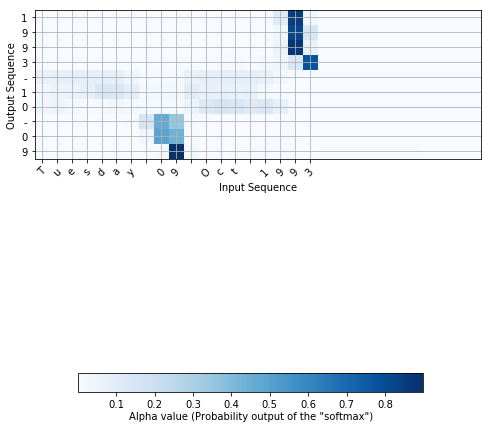

In [21]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)